# Scenario 4: Hierarchical Modeling (see [here](https://github.com/DARPA-ASKEM/program-milestones/blob/main/Nov-24-monthly-epi-demo/Nov%202024%20Monthly%20Demo%20Scenarios_FINAL.pdf))

In this scenario, we have simulated data from a geographic region. This region is made up of three counties, A, C, and C, and each county consists of two cities. The cities are numbered 1-6. Cities in the same county have similar transmission rates (drawn from the same distribution), but transmission rates vary stochastically over time. Counties do not share similar transmission rates with other counties.

The simulated dataset has 100 days of data for each city. Each day contains 10 timesteps, so there are 1000 observations for each city.

<img width="373" alt="Screenshot 2024-11-12 at 4 41 16 PM" src="https://github.com/user-attachments/assets/14751921-83e4-4208-8c07-a2b60c574ae0">

Epidemiological data can be imperfect, and you will find that to be the case within these counties. Specifically:
* In County A, City 1, a large chunk of the data is missing due to a month-long issue with the city's data collection system.
* In County B, City 3, data was not collected regularly, and thus there are gaps missing in the data. About 30% of the timepoints have no data collected for them. 
* In County C, City 6, the mayor of the city implemented an intervention 30% of the way through the period to reduce transmission rates even further. The same intervention was not applied in any other county or city.

The governor of the region is interested in answering a series of questions about the cities and counties. The data is recorded in an SEIR format, which follows these equations:
```math
\begin{align}
\frac{dS}{dt} &= - \beta S \frac{I}{N} \\
\frac{dE}{dt} &= \beta S \frac{I}{N} - \alpha E \\
\frac{dI}{dt} &= \alpha E - \gamma I \\
\frac{dR}{dt} &= \gamma I
\end{align}
```
The initial conditions of the cities and the data for each city are provided in the `S4_data.csv` file. (Initial conditions are also listed below)

<img width="706" alt="Screenshot 2024-11-12 at 4 56 48 PM" src="https://github.com/user-attachments/assets/7365e7de-ec7f-4f16-83e2-97b871344bff">

Problems:
1. Estimate city-level transmission rates. (a) use the data provided to estimate $\beta$ for Cities 1-5 without incorporating information from any other cities. (b) For County C, City 6, note that the intervention was implemented starting at `t = 30` days. Estimate the transmission rate before and after the intervention took place.
2. Using the data provided, estimate both county and regional transmission rates. Additionally, estimate transmission rates for each city, this time by incorporating information from other cities. Note any differences from the result in Q1.
3. For County A, City 1, impute the missing chunk of data using (1) the model that incorporated information from other cities and (2) the model which did not incorporate or include information from other cities. Plot both estimated SEIR curves and compare.
4. Repeat the same exercise in Q3 for County B, City 3.
5. **(Counterfactuals)** Imagine that the intervention applied in County C, City 6 had also been applied to County B, City 3 and City 4, at the same time. How would this have reduced the total number of infections in County B across the duration of time that the data was collected?
6. **(Optimization – choose a geography)** The governor of the region is aware of a new variant that has started to spread in a different region, and the governor fears that it may cause potential damage to the cities and counties they oversee. The best estimate of the transmission rate for this new variant is 1.2x as transmissible as previous variants.

   The governor has funding to apply an intervention in 2 of the 6 cities and is interested in minimizing the total number of infections in each city. The intervention is expected to reduce the transmission rate of the new variant to 80% of its previous transmissibility rate. The intervention would start at t=100 timesteps (day 10) and can run for the rest of the period (up to day 100). For this question, initial conditions are the same as Table 1.

   In which cities should the governor implement the intervention? By implementing the intervention, what are the total number of infections the governor would expect over a 1000-timestep (100 day) period, and what are the total number of infections the governor would expect if they chose to do nothing? Provide 90% intervals on all projections.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoMultivariateNormal
import pandas as pd

from chirho.dynamical.handlers import (
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = "CI" in os.environ
num_steps = 10 if smoke_test else 200
num_samples = 10 if smoke_test else 200

## Plotting utils

In [61]:
line_styles = ["solid", "dashed", "dotted", "dashdot"]
colors = {"S": "blue", "E": "black", "I": "red", "R": "green"}

def SEIR_uncertainty_plot(time_period, state_pred, color, ax, linestyle="solid"):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0) if state_pred.ndim > 1 else state_pred,
        color=color,
        linestyle=linestyle,
        ax=ax,
    )

    if state_pred.ndim > 1:
        # 95% Credible Interval
        ax.fill_between(
            time_period,
            torch.quantile(state_pred, 0.025, dim=0),
            torch.quantile(state_pred, 0.975, dim=0),
            alpha=0.2,
            color=color,
            label="95% Credible Interval",
        )


def SEIR_peak_plot(true_state, true_logging_times, ax):
    peak_idx = torch.argmax(true_state)
    ax.axvline(true_logging_times[peak_idx], color="red", label="Peak Infection Time")


def SEIR_data_plot(time_period, data, data_label, ax, color="black"):
    sns.scatterplot(x=time_period, y=data, color=color, ax=ax, label=data_label)


def SEIR_test_plot(test_start_time, test_end_time, ax):
    ax.axvline(
        test_start_time, color="black", linestyle=":", label="Measurement Period"
    )
    ax.axvline(test_end_time, color="black", linestyle=":")


def plot_seir_data(
    n_counties_per_region,
    n_cities_per_county,
    colors,
    seir_traj=None,
    logging_times=None,
    seir_data=None,
    obs_logging_times=None,
    true_traj=None,
    true_logging_times=None,
    plot_true_peak=False,
    main_title=None,
    n_compartments = 4

):
    """
    Plots SEIR (Susceptible, Exposed, Infected, Recovered) data for multiple cities.
    Parameters:
    n_counties_per_region (int): Number of counties per region.
    n_cities_per_county (int): Number of cities per county.
    colors (dict): Dictionary of colors for each compartment (keys: "S", "E", "I", "R").
    seir_traj (dict, optional): SEIR trajectory data to plot.
    logging_times (array-like, optional): Times at which SEIR trajectory data is logged.
    seir_data (DataFrame, optional): Observed SEIR data.
    obs_logging_times (array-like, optional): Times at which observed SEIR data is logged.
    true_traj (dict, optional): True SEIR trajectory data.
    true_logging_times (array-like, optional): Times at which true SEIR trajectory data is logged.
    plot_true_peak (bool, optional): Whether to plot the true peak of infections.
    main_title (str, optional): Main title for the plot.
    n_compartments (int, optional): Number of compartments to plot (default is 4).
    Returns:
    None
    """
    n_cities = n_counties_per_region * n_cities_per_county
    fig, ax = plt.subplots(n_cities, n_compartments, figsize=(15, 7), sharex=True, sharey=True)
    if main_title is not None:
        fig.suptitle(main_title, fontsize=16)

    if seir_data is not None:
        for i, city in enumerate(range(1, n_cities+1)):
            for j, key in enumerate(["S", "E", "I", "R"]):
                SEIR_data_plot(
                    obs_logging_times,
                    seir_data[seir_data["city"] == city][f"{key}_obs"],
                    color=colors[key],
                    ax=ax[i, j],
                    data_label=None,
                )
        

    if true_traj is not None:
        for i in range(n_cities_per_county):
            for j in range(n_counties_per_region):
                for k, key in enumerate(["S", "E", "I", "R"]):
                    SEIR_uncertainty_plot(
                        true_logging_times,
                        true_traj[key][i, j, :],
                        color="black",
                        ax=ax[i*n_counties_per_region+j, k],
                        linestyle="dashed",
                )

            if plot_true_peak:
                SEIR_peak_plot(true_traj["I"][i, j, :], true_logging_times, ax[i*n_counties_per_region + j, 2])

    if seir_traj is not None:
        for i in range(n_cities_per_county):
            for j in range(n_counties_per_region):
                for k, key in enumerate(["S", "E", "I", "R"]):
                    SEIR_uncertainty_plot(
                        logging_times,
                        seir_traj[key][..., 0, 0, i, j,  :],
                        color=colors[key],
                        ax=ax[i*n_counties_per_region + j, k],
                    )

    # Set x-axis labels
    ax[n_cities-1, 0].set_xlabel("Time (days)")
    ax[n_cities-1, 1].set_xlabel("Time (days)")
    ax[n_cities-1, 2].set_xlabel("Time (days)")
    ax[n_cities-1, 3].set_xlabel("Time (days)")


    for i in range(n_cities):
        if i == 0:
            ax[i, 0].set_title("Susceptible")
            ax[i, 1].set_title("Exposed")
            ax[i, 2].set_title("Infected")
            ax[i, 3].set_title("Recovered")

        ax_right_2 = ax[i, 3].twinx()
        ax_right_2.set_ylabel(f"City {i+1}", rotation=270, labelpad=15)
        ax_right_2.yaxis.set_label_position("right")
        ax_right_2.tick_params(right=False)
        ax_right_2.set_yticklabels([])

    ax[0, 0].set_ylabel("")
    ax[1, 0].set_ylabel("")
    ax[2, 0].set_ylabel("Number of individuals")
    ax[3, 0].set_ylabel("")
    ax[4, 0].set_ylabel("")
    ax[5, 0].set_ylabel("")

    plt.tight_layout()
    plt.show()


def plot_seir_marginals(
    county_colors,
    city_colors,
    alpha_mean,
    beta_mean,
    gamma_mean,
    alphas,
    betas,
    gammas,
    alpha_true,
    beta_true,
    gamma_true,
    title,
    xlim=None,
    ylim=None,
    bw_adjust=1,
):
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    for i, county in enumerate(county_colors):
        sns.kdeplot(
            alpha_mean[:, i],
            ax=ax[0],
            color=county_colors[county],
            label=f"county {county} mean $\\alpha$",
            linewidth=3,
            bw_adjust=bw_adjust,
        )

    for loc, alpha in enumerate(alphas):

        sns.kdeplot(
            alpha,
            ax=ax[0],
            alpha=0.4,
            color=city_colors[loc],
            label=f"city {loc} $\\alpha$",
            linewidth=1.5,
            bw_adjust=bw_adjust,
        )

        ax[0].axvline(
            alpha_true[loc//3, loc%3],
            color=city_colors[loc],
            label=f"city {loc} ground truth",
            linestyle="--",
        )

    ax[0].legend()
    for i, county in enumerate(county_colors):
        sns.kdeplot(
            beta_mean[:, i],
            ax=ax[1],
            color=county_colors[county],
            label=f"county {county} mean $\\beta$",
            linewidth=3,
            bw_adjust=bw_adjust,
        )

    for loc, beta in enumerate(betas):

        sns.kdeplot(
            beta,
            ax=ax[1],
            alpha=0.4,
            color=city_colors[loc],
            label=f"city {loc} $\\beta$",
            linewidth=1.5,
            bw_adjust=bw_adjust,
        )

        ax[1].axvline(
            beta_true[loc//3, loc%3],
            color=city_colors[loc],
            label=f"city {loc} ground truth",
            linestyle="--",
        )

    ax[1].legend()
    
    for i, county in enumerate(county_colors):
        sns.kdeplot(
            gamma_mean[:, i],
            ax=ax[2],
            color=county_colors[county],
            label=f"county {county} mean $\\gamma$",
            linewidth=3,
            bw_adjust=bw_adjust,
        )
    for loc, gamma in enumerate(gammas):
        sns.kdeplot(
            gamma,
            ax=ax[2],
            alpha=0.4,
            color=city_colors[loc],
            label=f"city {loc} $\\gamma$",
            linewidth=1.5,
            bw_adjust=bw_adjust,
        )
        ax[2].axvline(
            gamma_true[loc//3, loc%3],
            color=city_colors[loc],
            label=f"city {loc} ground truth",
            linestyle="--",
        )

    ax[2].legend()

    if xlim is not None:
        ax[0].set_xlim(xlim)
        ax[1].set_xlim(xlim)
        ax[2].set_xlim(xlim)

    if ylim is not None:
        ax[0].set_ylim(ylim)
        ax[1].set_ylim(ylim)
        ax[2].set_ylim(ylim)

    fig.suptitle(title, fontsize=16)

    fig.tight_layout()
    sns.despine()
    fig.show()

## Causal probabilistic program

In [77]:
class SEIRDynamics(pyro.nn.PyroModule):
    def __init__(self, alpha, beta, gamma):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        S, E, I, R = X["S"], X["E"], X["I"], X["R"]
        N = S + E + I + R
        dS = -self.beta * S * I / N
        dE = self.beta * S * I / N - self.alpha * E
        dI = self.alpha * E - self.gamma * I
        dR = self.gamma * I
        return {"S": dS, "E": dE, "I": dI, "R": dR}


def seir_observation_model(X: State[torch.Tensor]) -> None:
    # Note: Here we set the event_dim to 1 if the last dimension of X["I"] is > 1, as the seir_observation_model
    # can be used for both single and multi-dimensional observations.
    event_dim = 1 if X["I"].shape and X["I"].shape[-1] > 3 else 0
    pyro.sample(
       "S_obs", dist.Normal(X["S"], torch.as_tensor(1.0)).to_event(event_dim)
    )  # noisy number of susceptible actually observed
    pyro.sample(
       "E_obs", dist.Normal(X["E"], torch.as_tensor(1.0)).to_event(event_dim)
    )  # noisy number of exposed actually observed
    pyro.sample(
        "I_obs", dist.Normal(X["I"], torch.as_tensor(1.0)).to_event(event_dim)
    )  # noisy number of infected actually observed
    pyro.sample(
        "R_obs", dist.Normal(X["R"], torch.as_tensor(1.0)).to_event(event_dim)
    )  # noisy number of recovered actually observed


def single_city_observation_model(X: State[torch.Tensor], city: int) -> None:
    # In this example we only take noisy measurements of a single city corresponding to
    # the first index in the state tensors (0 in the second-last dimension, the last dimension is time).
    city_X = {k: v[..., city, :] for k, v in X.items()}
    return seir_observation_model(city_X)

## Initial conditions

<img width="706" alt="Screenshot 2024-11-12 at 4 56 48 PM" src="https://github.com/user-attachments/assets/7365e7de-ec7f-4f16-83e2-97b871344bff">


In [38]:
n_cities_per_county = 2
n_counties_per_region = 3
n_cities = n_cities_per_county * n_counties_per_region
N = torch.tensor([1000.0, 1200.0, 500.0, 1500.0, 2000.0, 10000.0])
cities = {f"city {i+1}": i for i in range(n_cities)}
# Initial conditions for hierarchical modeling scenario. All units are in terms of population (number of people)
init_state = dict(
    S=torch.tensor([999.0, 1199.0, 499.0, 1499.0, 1950.0, 9900.0]).reshape(n_cities_per_county, n_counties_per_region), 
    E=torch.tensor([1.0, 1.0, 1.0, 1.0, 50.0, 100.0]).reshape(n_cities_per_county, n_counties_per_region),
    I=torch.zeros(n_cities_per_county, n_counties_per_region),
    R=torch.zeros(n_cities_per_county, n_counties_per_region),
)
start_time = torch.tensor(0.0)
end_time = torch.tensor(100.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)

# We now simulate from the SEIR model. Notice that the true parameters are similar to each other,
# but not exactly the same.
alpha_true = torch.tensor([0.1, 0.15, 0.12, 0.13, 0.14, 0.11]).reshape(n_cities_per_county, n_counties_per_region)
beta_true = torch.tensor([0.4, 0.385, 0.405, 0.4, 0.385, 0.405]).reshape(n_cities_per_county, n_counties_per_region)
gamma_true = torch.tensor([0.5, 0.55, 0.52, 0.53, 0.54, 0.51]).reshape(n_cities_per_county, n_counties_per_region)

seir_true = SEIRDynamics(alpha_true, beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(seir_true, init_state, start_time, end_time)

seir_true_traj = lt.trajectory

obs_start_time = torch.tensor(0.0)  # Measurements start 0.5 months into the pandemic
obs_sample_rate = torch.tensor(0.1)  # Take measurements once per week
obs_end_time = torch.tensor(100.0)  # Measurements end after 6th month

obs_logging_times = torch.arange(obs_start_time, obs_end_time, obs_sample_rate)
N_obs = obs_logging_times.shape[0]
with TorchDiffEq(), LogTrajectory(obs_logging_times) as lt_obs:
    simulate(seir_true, init_state, start_time, obs_end_time)

seir_obs_traj = lt_obs.trajectory
with pyro.poutine.trace() as tr:
    # Suppose we only observe the number of infected and recovered individuals in the first city.
    single_city_observation_model(seir_obs_traj, 0)
observed_columns = {"S": "S_obs", "E": "E_obs", "I": "I_obs", "R": "R_obs"}
seir_data = pd.read_csv("S4_data.csv",index_col=0).rename(columns=observed_columns)#.set_index(["county", "city"])
seir_data[seir_data["city"] == 2]

,t,S_obs,E_obs,I_obs,R_obs,city,county
1001,0.0,1199.000000,1.000000,0.000000,0.000000,2,A
1002,0.1,1199.000000,0.980000,0.020000,0.000000,2,A
1003,0.2,1198.998724,0.961676,0.039400,0.000200,2,A
1004,0.3,1198.996179,0.944988,0.058240,0.000594,2,A
1005,0.4,NaN,NaN,NaN,NaN,2,A
...,...,...,...,...,...,...,...
1996,99.5,0.714675,0.031103,4.667309,1194.586914,2,A
1997,99.6,0.714462,0.030694,4.621258,1194.633587,2,A
1998,99.7,0.714250,0.030291,4.575659,1194.679799,2,A
1999,99.8,0.714041,0.029895,4.530508,1194.725556,2,A


In [75]:
seir_obs_traj['S'].shape

torch.Size([2, 3, 1000])

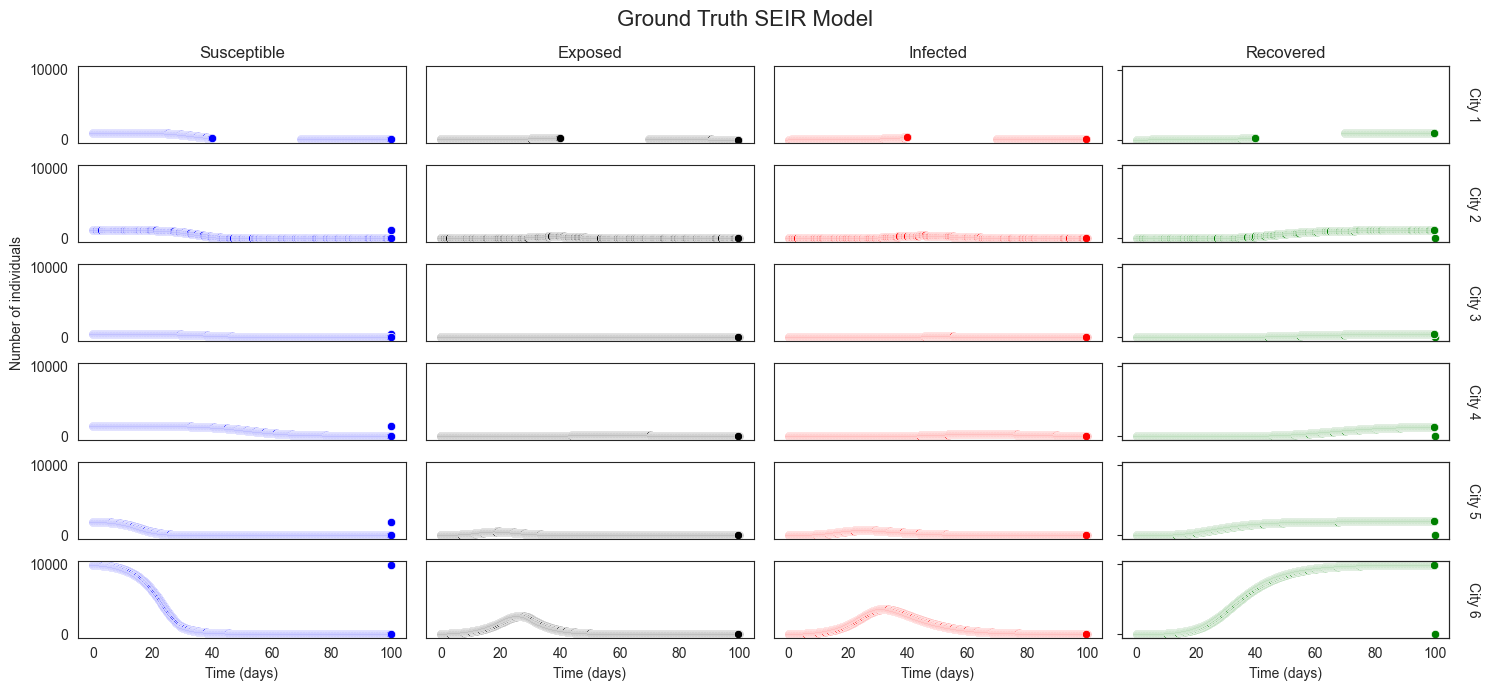

In [39]:
plot_seir_data(
    n_cities,
    colors=colors,
    seir_data=seir_data.reset_index(),
    main_title="Ground Truth SEIR Model",
    obs_logging_times=seir_data["t"],
)

## Multi-level Bayesian model

Now we introduce a multi-level structure of uncertainty about the parameters. For local parameters we'll be using Gamma distributions, which - for convenience - we reparametrize in terms of mean and standard deviation. These will be sampled around group-level coefficients, the uncertainty about which will be expressed in terms of Beta distributions.

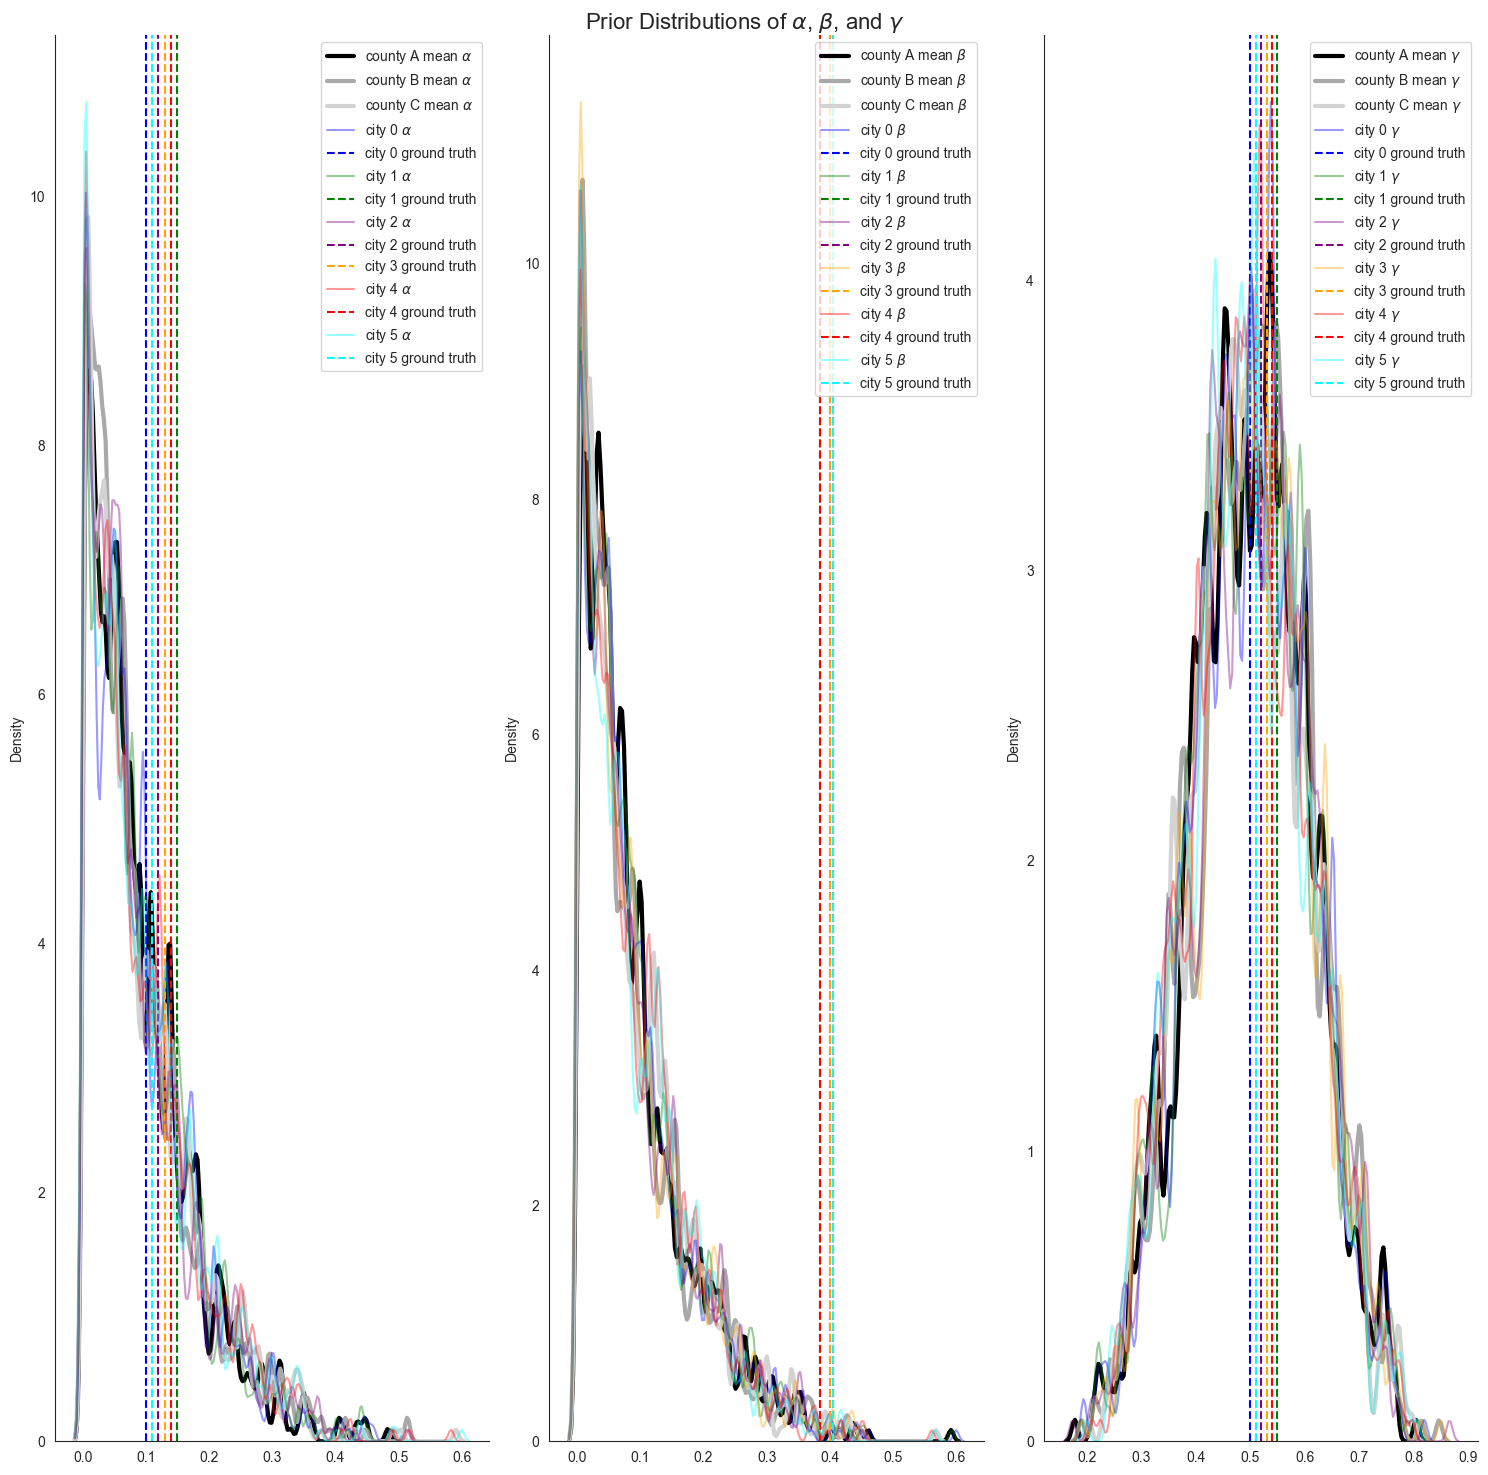

In [42]:
def reparameterize_inverse_gamma(mean, std):
    alpha = 2 + mean**2 / std**2
    beta = mean * (alpha - 1)
    return alpha, beta


def bayesian_multilevel_seir_prior(
    n_counties_per_region: int, n_cities_per_county: int
) -> tuple[torch.Tensor, torch.Tensor, pyro.plate]:
    
    counties = pyro.plate("counties", size=n_counties_per_region, dim=-1)

    with counties:
        alpha_mean = pyro.sample("alpha_mean", dist.Beta(1, 10))
        alpha_std = 0.01
        beta_mean = pyro.sample("beta_mean", dist.Beta(1, 10))
        beta_std = 0.01

        gamma_mean = pyro.sample("gamma_mean", dist.Beta(10, 10))
        gamma_std = 0.01

        cities = pyro.plate("cities", size=n_cities_per_county, dim=-2)

        with cities:
            alpha = pyro.sample(
                "alpha",
                dist.InverseGamma(*reparameterize_inverse_gamma(alpha_mean, alpha_std)),
            )
            beta = pyro.sample(
                "beta",
                dist.InverseGamma(*reparameterize_inverse_gamma(beta_mean, beta_std)),
            )
            gamma = pyro.sample(
                "gamma",
                dist.InverseGamma(*reparameterize_inverse_gamma(gamma_mean, gamma_std)),
            )
    return alpha, beta, gamma, counties, cities


# let's illustrate prior distributions: they should be similar but not identical

with pyro.poutine.trace() as tr:
    with pyro.plate("samples", num_samples * 5, dim=-3):
        bayesian_multilevel_seir_prior(n_counties_per_region, n_cities_per_county)

alpha_mean = tr.trace.nodes["alpha_mean"]["value"].detach().squeeze().numpy()
beta_mean = tr.trace.nodes["beta_mean"]["value"].detach().squeeze().numpy()
gamma_mean = tr.trace.nodes["gamma_mean"]["value"].detach().squeeze().numpy()

alphas = tr.trace.nodes["alpha"]["value"].detach().squeeze().numpy()
alphas = [alphas[:, 0, 0], alphas[:, 1, 0], alphas[:, 0, 1], alphas[: 1, 1], alphas[:, 0, 2], alphas[:, 1, 2]]

betas = tr.trace.nodes["beta"]["value"].detach().squeeze().numpy()
betas = [betas[:, 0, 0], betas[:, 1,  0], betas[:, 0, 1], betas[:, 1, 1], betas[:, 0, 2], betas[:, 1, 2]]
gammas = tr.trace.nodes["gamma"]["value"].detach().squeeze().numpy()
gammas = [gammas[:, 0, 0], gammas[:, 1, 0], gammas[:, 0, 1], gammas[:, 1, 1], gammas[:, 0, 2], gammas[:, 1, 2]]
# adjust bw to illustrate variance between sampling
# and to avoid oversmoothing,
# "plotting" non-existent values below
# zero as present
county_colors = {'A': 'black', 'B': 'darkgrey', 'C': 'lightgrey'}
city_colors = ["blue", "green", "purple", "orange", "red", "cyan"]

plot_seir_marginals(
    county_colors,
    city_colors,
    alpha_mean,
    beta_mean,
    gamma_mean,
    alphas,
    betas,
    gammas,
    alpha_true,
    beta_true,
    gamma_true,
    "Prior Distributions of $\\alpha$, $\\beta$, and $\\gamma$",
    bw_adjust=0.2,
)

Now we put some components together. Frist we sample the parameters, then we pass them on to `TorchDiffEq` to simulate

In [50]:
def simulated_multilevel_bayesian_seir(
    init_state, start_time, logging_times, base_model=SEIRDynamics, is_traced=True, n_regions=1, n_counties_per_region=3, n_cities_per_county=2
) -> State[torch.Tensor]:
    n_cities = n_counties_per_region * n_cities_per_county * n_regions
    assert init_state["I"].shape == init_state["R"].shape == (n_cities_per_county, n_counties_per_region)
    alpha, beta, gamma, _, _ = bayesian_multilevel_seir_prior(n_counties_per_region, n_cities_per_county )
    seir = base_model(alpha, beta, gamma)
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=is_traced) as lt:
        simulate(seir, init_state, start_time, logging_times[-1])
    return lt.trajectory

This results in a model with the following structure:

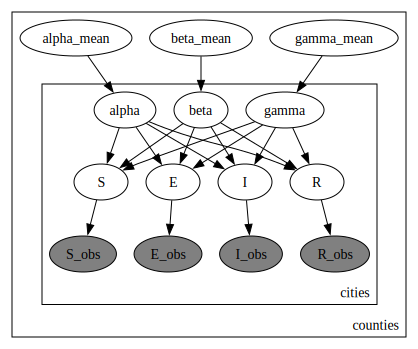

In [78]:
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
def rendering_model(n_counties_per_region, n_cities_per_county) -> State[torch.Tensor]:

    alpha, beta, gamma, counties, cities = bayesian_multilevel_seir_prior(n_counties_per_region, n_cities_per_county)
    n_cities = n_counties_per_region * n_cities_per_county
    seir = SEIRDynamics(alpha, beta, gamma)
    state = dict(
        S=torch.ones( n_cities_per_county, n_counties_per_region) * 99, 
        E=torch.ones( n_cities_per_county, n_counties_per_region), 
        I=torch.zeros( n_cities_per_county, n_counties_per_region,), 
        R=torch.zeros( n_cities_per_county, n_counties_per_region)
    )
    deriv = seir(state)
    state = {k: v + deriv[k] * 0.1 for k, v in state.items()}
    deriv = seir(state)
    state = {k: v + deriv[k] * 0.1 for k, v in state.items()}
    deriv = seir(state)
    state = {k: v + deriv[k] * 0.1 for k, v in state.items()}
    # with cities:
    #     state = {k: pyro.sample(k, dist.Delta(v)) for k, v in state.items()}
    N_obs = 1
    with cities:#counties:
        with counties:
            state = {k: pyro.sample(k, dist.Delta(v)) for k, v in state.items()}
            with pyro.condition(
                data={
                    "S_obs": torch.ones(n_cities_per_county, n_counties_per_region),
                    "E_obs": torch.zeros(n_cities_per_county, n_counties_per_region),
                    "I_obs": torch.ones(n_cities_per_county, n_counties_per_region),
                    "R_obs": torch.zeros(n_cities_per_county, n_counties_per_region)} 
            ):
                seir_observation_model(state)

    return state
pyro.render_model(rendering_model, model_args=(n_counties_per_region, n_cities_per_county), filename="multi_seir.png", render_deterministic=True)


In [52]:
state = rendering_model(n_counties_per_region, n_cities_per_county)
state['S'].shape
event_dim=0
pyro.sample(
        "S_obs", dist.Normal(state["S"], torch.as_tensor(1.0)).to_event(event_dim)
    ) 

tensor([[ 99.1180, 100.2789,  99.9713],
        [ 99.1749,  98.9416,  99.7958]])

In [59]:
num_samples

200

torch.Size([200, 1, 1, 2, 3, 1000])


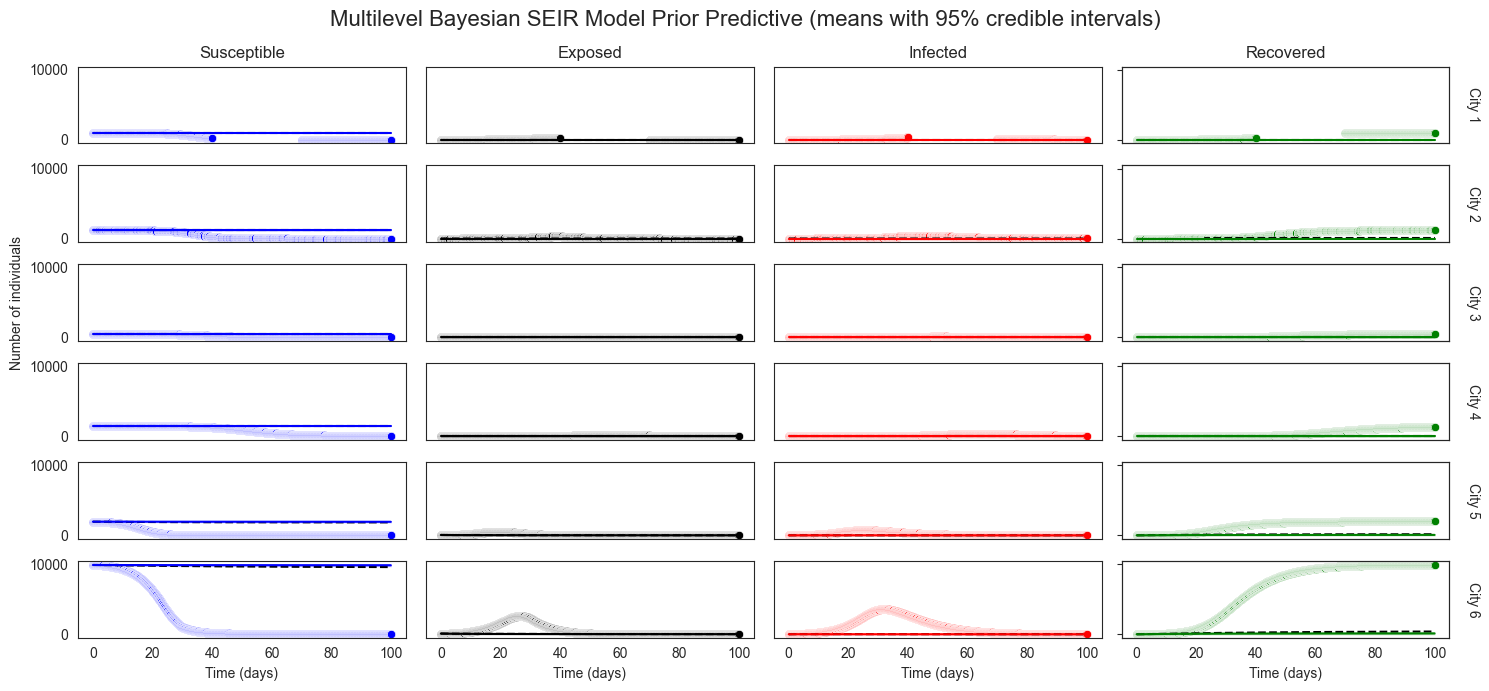

In [62]:
prior_predictive = Predictive(
    simulated_multilevel_bayesian_seir, num_samples=num_samples, parallel=True
)
prior_samples = prior_predictive(init_state, start_time, logging_times)
print(prior_samples["S"].shape)

plot_seir_data(
    n_counties_per_region=n_counties_per_region,
    n_cities_per_county=n_cities_per_county,
    colors=colors,
    true_traj=seir_true_traj,
    true_logging_times=logging_times,
    seir_traj=prior_samples,
    logging_times=logging_times,
    seir_data=seir_data,
    obs_logging_times=obs_logging_times,
    main_title="Multilevel Bayesian SEIR Model Prior Predictive (means with 95% credible intervals)",
)

We can see that without any data our prior has induced extremely broad uncertainty over resulting disease dynamics.

## Bayesian Partial Pooling with Dynamical Systems

### Probabilistic Inference over Dynamical System Parameters

One of the major benefits of writing our dynamical systems model in Pyro and ChiRho is that we can leverage Pyro's support for (partially) automated probabilistic inference. In this section we'll (i) condition on observational data using the `StaticBatchObservation` effect handler and (ii) optimize a variational approximation to the posterior using Pyro's SVI utilities.

In [72]:
seir_data[seir_data["city"] == 2]

,t,S_obs,E_obs,I_obs,R_obs,city,county
1001,0.0,1199.000000,1.000000,0.000000,0.000000,2,A
1002,0.1,1199.000000,0.980000,0.020000,0.000000,2,A
1003,0.2,1198.998724,0.961676,0.039400,0.000200,2,A
1004,0.3,1198.996179,0.944988,0.058240,0.000594,2,A
1005,0.4,NaN,NaN,NaN,NaN,2,A
...,...,...,...,...,...,...,...
1996,99.5,0.714675,0.031103,4.667309,1194.586914,2,A
1997,99.6,0.714462,0.030694,4.621258,1194.633587,2,A
1998,99.7,0.714250,0.030291,4.575659,1194.679799,2,A
1999,99.8,0.714041,0.029895,4.530508,1194.725556,2,A


In [69]:
def conditioned_seir(
    obs_times, data, init_state, start_time, base_model=SEIRDynamics, city=0
) -> None:
    n_counties_per_region = init_state["S"].shape[-1]
    n_cities_per_county = init_state["S"].shape[-2]
    assert init_state["E"].shape == init_state["I"].shape == init_state["R"].shape == (n_cities_per_county, n_counties_per_region)

    alpha, beta, gamma, _, _ = bayesian_multilevel_seir_prior(n_counties_per_region=n_counties_per_region, n_cities_per_county=n_cities_per_county)
    seir = base_model(alpha, beta, gamma)
    obs = condition(data=data[data['city'] == city])(lambda state: single_city_observation_model(state, city))
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(seir, init_state, start_time, obs_times[-1])


# Define a helper function to run SVI.
# (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(
    model,
    num_steps=num_steps,
    verbose=True,
    lr=0.03,
    vi_family=AutoMultivariateNormal,
    guide=None,
    **model_kwargs
):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 25 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [70]:
# Run inference to approximate the posterior distribution of the SIR model parameters
seir_guide = run_svi_inference(
    conditioned_seir,
    num_steps=num_steps,
    obs_times=obs_logging_times,
    data=seir_data,
    init_state=init_state,
    start_time=start_time,
)

ValueError: Error while computing log_prob at site 'S_obs':
The value argument to log_prob must be a Tensor
  Trace Shapes:         
   Param Sites:         
  Sample Sites:         
alpha_mean dist      3 |
          value      3 |
       log_prob      3 |
 beta_mean dist      3 |
          value      3 |
       log_prob      3 |
gamma_mean dist      3 |
          value      3 |
       log_prob      3 |
     alpha dist 2    3 |
          value 2    3 |
       log_prob 2    3 |
      beta dist 2    3 |
          value 2    3 |
       log_prob 2    3 |
     gamma dist 2    3 |
          value 2    3 |
       log_prob 2    3 |
     S_obs dist 2 1000 |
          value      0 |

In [ ]:
import pandas as pd
def identify_nans(data_df, return_labels=False):
    """
    Identifies and returns all types of NaNs in the DataFrame:
    1. Entire rows that are NaN.
    2. Entire columns that are NaN.
    3. Individual elements that are NaN.

    Parameters:
    data_df (pd.DataFrame): The input DataFrame.
    return_labels (bool): If True, return row and column names; otherwise, return indices.

    Returns:
    dict: A dictionary containing indices or labels for each type of NaN.
    """
    # Identify entire rows that are NaN
    nan_rows = data_df.index[data_df.isna().all(axis=1)].tolist()
    nan_row_idx = [data_df.index.get_loc(row) for row in nan_rows]

    # Identify entire columns that are NaN
    nan_columns = data_df.columns[data_df.isna().all(axis=0)].tolist()
    nan_columns_idx = [data_df.columns.get_loc(col) for col in nan_columns]

    # Identify individual elements that are NaN
    nan_elements = [(row, col) 
                        for row in data_df.index 
                        for col in data_df.columns 
                        if col not in nan_columns and
                         row not in nan_rows and 
                         pd.isna(data_df.loc[row, col])]

    nan_elements_idx = [(data_df.index.get_loc(row), data_df.columns.get_loc(col)) 
                            for row, col in nan_elements]
    return {
        "nan_rows": nan_rows if return_labels else nan_row_idx,
        "nan_columns": nan_columns if return_labels else nan_columns_idx,
        "nan_elements": nan_elements if return_labels else nan_elements_idx
    }

# Example usage
data = {
    'A': [1, 2, None, 4],
    'B': [None, None, None, None],
    'C': [None, None, None, None],
    'D': [1, 2, None, None]
}
df = pd.DataFrame(data,index=['a','b','c','d'])
nan_info = identify_nans(df, return_labels=False)

print("Rows with all NaNs:")
print(nan_info["nan_rows"])
print("\nColumns with all NaNs:")
print(nan_info["nan_columns"])
print("\nelements with individual NaNs:")
print(nan_info["nan_elements"])
display(df)